# Find nights with Auxtel Spectra in OGA butler

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-01-11
- last update : 2024-02-19
- affiliation : IJCLab/IN2P3/CNRS



- Work with w_2024_07

The goal is to check the number of data available, their date.

## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time

In [2]:
import matplotlib.ticker
%matplotlib inline

In [3]:
import spectractor
from spectractor.simulation.throughput import load_transmission,plot_transmission_simple,TelescopeTransmission
from spectractor import parameters
from spectractor.extractor import dispersers
from spectractor.config import load_config,set_logger
import os,sys

In [4]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [5]:
import lsst.daf.butler as dafButler

repo = "/repo/main"
repo = "/repo/embargo"
# repo = "LATISS"
butler = dafButler.Butler(repo)
registry = butler.registry

for c in sorted(registry.queryCollections()):
    #if "u/jneveu" in c and "auxtel_atmo" in c:
    #if "u/dagoret" in c:
    if "u/dagoret" in c and "auxtel_atmo" in c:
        print(c)

u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsPTC_rebin2_231208
u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsPTC_rebin2_231208/20231220T142452Z
u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221
u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221/20231221T125249Z
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208/20231208T215202Z
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208/20231208T211104Z
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240201
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240201/20240201T144534Z
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N149.5
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N149.5/20240215T190316Z
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N150
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N150/2024

## Config

### Config collection

In [6]:
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208"
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208"

# all spectra from September 2022 to december 2023
#the reconstruction done by  LambdaMin = 350.0 and spectractor v3.0.3 in 2023/12/21
#my_collection = "u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221"


# work done 5th Feb 2024
#my_collection = "u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsPTC_rebin2_240201"


#work done 19th Feb 2024
my_collection = "u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsPTC_rebin2_240218_N150"
#my_collection = "u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N150"

### Config Auxtel

In [7]:
#config_path = "~/repos/repos_w_2023_44/Spectractor/config/auxtel.ini"
#config_path = "/home/d/dagoret/repos/repos_w_2023_44/Spectractor/config/auxtel.ini"
#config_fullpath = os.path.join(spectractor.__path__[0],"../config/auxtel.ini")
throughput_filename="multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt"

In [8]:
#load_config(config_fullpath)

## Check the presence of the spectra

### select the date of observation

### Fitted param file output name

- Note each date is overwritted inside the hdf5 file

In [9]:
#fitted_paramfile = f"fitted_atmparamfile_{DATEOBS}.hdf5"
fitted_paramfile = "fitted_atmparamfile_29jan-15feb2024.hdf5"

## Access to spectra using the butler

In [10]:
#where = f"instrument='LATISS' and visit.day_obs={DATEOBS}" 
where = "instrument='LATISS' "
records = list(butler.registry.queryDimensionRecords('visit', datasets='spectractorSpectrum', where=where,  collections=my_collection))
# records = list(butler.registry.queryDimensionRecords('visit', datasets='raw', where=where))

In [11]:
print(">>> Number of records : ",len(records))
records[-1]

>>> Number of records :  80


visit.RecordClass(instrument='LATISS', id=2024021500294, physical_filter='empty~holo4_003', name='AT_O_20240215_000294', day_obs=20240215, seq_num=294, exposure_time=60.0, target_name='HD185975', observation_reason='object', science_program='spec-survey', azimuth=177.8689729616169, zenith_angle=61.57702289458239, region=ConvexPolygon([UnitVector3d(0.02569546792896837, -0.034126357208521314, -0.9990871506888614), UnitVector3d(0.027800996992706807, -0.03437491666392165, -0.9990222568444409), UnitVector3d(0.02755433711753972, -0.03644696269350863, -0.9989556433678279), UnitVector3d(0.025448808053288807, -0.03619840312949191, -0.9990205372160983)]), timespan=Timespan(begin=astropy.time.Time('2024-02-16 06:42:02.329992', scale='tai', format='iso'), end=astropy.time.Time('2024-02-16 06:43:02.569000', scale='tai', format='iso')))

### List first of first records

       visit:
          instrument
          id
          physical_filter
          name: 'AT_O_20231220_000354'
         day_obs
         seq_num
         exposure_time
         target_name
         observation_reason
         science_program: 
         azimuth
         zenith_angle
         timespan

In [12]:
df_spec = pd.DataFrame(columns=['id',
                                'name',
                                'day_obs', 
                                'seq_num',
                                'time_start',
                                'time_end', 
                                'target',
                                'filter',
                                'exposure_time',
                                'azimuth',
                                'zenith',
                                'obs_reason',
                                'science_program',
                                'jd',
                                'mjd'])

In [13]:
for count, info in enumerate(registry.queryDimensionRecords('visit', datasets='spectractorSpectrum', where=where,  collections=my_collection)):
       
    try:
        df_spec.loc[count] = [info.id, info.name, info.day_obs, info.seq_num,pd.to_datetime(info.timespan.begin.to_string()),pd.to_datetime(info.timespan.end.to_string()) ,
                                  info.target_name, info.physical_filter, info.exposure_time, info.azimuth,info.zenith_angle, info.observation_reason, info.science_program,
                                  info.timespan.begin.jd,info.timespan.begin.mjd ]
    except:
        print(">>>   Unexpected error:", sys.exc_info()[0])
        info_timespan_begin_to_string = "2021-01-01 00:00:00.00"
        info_timespan_end_to_string = "2051-01-01 00:00:00.00"
        info_timespan_begin_jd = 0
        info_timespan_begin_mjd = 0
        df_spec.loc[count] = [info.id, info.name, info.day_obs, info.seq_num,
                                  pd.to_datetime(info_timespan_begin_to_string),
                                  pd.to_datetime(info_timespan_end_to_string) ,
                                  info.target_name, 
                                  info.physical_filter, info.exposure_time,info.azimuth,info.zenith_angle,
                                  info.zenith_angle,  info.observation_reason, info.science_program, info_timespan_begin_jd, info_timespan_begin_mjd  ]
 

In [14]:
df_spec

,id,name,day_obs,seq_num,time_start,time_end,target,filter,exposure_time,azimuth,zenith,obs_reason,science_program,jd,mjd
0,2024012900294,AT_O_20240129_000294,20240129,294,2024-01-30 01:12:17.013008,2024-01-30 01:13:17.253,HD38666,empty~holo4_003,60.0,105.356590,9.438961,object,spec-survey,2.460340e+06,60339.050197
1,2024012900323,AT_O_20240129_000323,20240129,323,2024-01-30 01:56:30.220986,2024-01-30 01:57:30.451,HD185975,empty~holo4_003,60.0,182.000283,61.666446,object,spec-survey,2.460340e+06,60339.080905
2,2024012900324,AT_O_20240129_000324,20240129,324,2024-01-30 01:57:43.133003,2024-01-30 01:58:43.374,HD185975,empty~holo4_003,60.0,181.988470,61.675620,object,spec-survey,2.460340e+06,60339.081749
3,2024012900330,AT_O_20240129_000330,20240129,330,2024-01-30 02:05:40.462017,2024-01-30 02:06:40.701,HD2811,empty~holo4_003,60.0,233.085770,63.721889,object,spec-survey,2.460340e+06,60339.087274
4,2024012900331,AT_O_20240129_000331,20240129,331,2024-01-30 02:06:53.489020,2024-01-30 02:07:53.720,HD2811,empty~holo4_003,60.0,233.009871,63.932135,object,spec-survey,2.460340e+06,60339.088119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2024021500246,AT_O_20240215_000246,20240215,246,2024-02-16 05:35:36.637992,2024-02-16 05:36:36.884,HD185975,empty~holo4_003,60.0,178.559289,62.019631,object,spec-survey,2.460357e+06,60356.233063
76,2024021500252,AT_O_20240215_000252,20240215,252,2024-02-16 05:43:41.196981,2024-02-16 05:44:11.443,HD38666,empty~holo4_003,30.0,247.027941,61.920335,object,spec-survey,2.460357e+06,60356.238671
77,2024021500253,AT_O_20240215_000253,20240215,253,2024-02-16 05:44:24.305015,2024-02-16 05:44:54.546,HD38666,empty~holo4_003,30.0,246.969650,62.063069,object,spec-survey,2.460357e+06,60356.239170
78,2024021500293,AT_O_20240215_000293,20240215,293,2024-02-16 06:40:49.244007,2024-02-16 06:41:49.482,HD185975,empty~holo4_003,60.0,177.880300,61.586790,object,spec-survey,2.460357e+06,60356.278348


In [15]:
df_spec["year"] = df_spec["day_obs"].apply(lambda x : x//10_000)
df_spec["yearmonth"] = df_spec["day_obs"].apply(lambda x : x//100)
df_spec["time"] = pd.to_datetime(df_spec['time_start'])

In [16]:
df_spec["day_obs"].unique()

array([20240129, 20240130, 20240131, 20240205, 20240206, 20240207,
       20240212, 20240213, 20240214, 20240215])

### Time series

In [17]:
df_spec_visit = df_spec.groupby(['day_obs']).count()["id"]
df_spec_visit.name = "countVisitperBandperNight" 
df_spec_visit

day_obs
20240129     5
20240130     5
20240131     2
20240205     3
20240206    14
20240207     4
20240212    12
20240213    16
20240214    13
20240215     6
Name: countVisitperBandperNight, dtype: int64

Text(0.5, 1.0, 'Auxtel Spectro Year 2024 nspec = 80 ndays = 10 (/repo/embargo)')

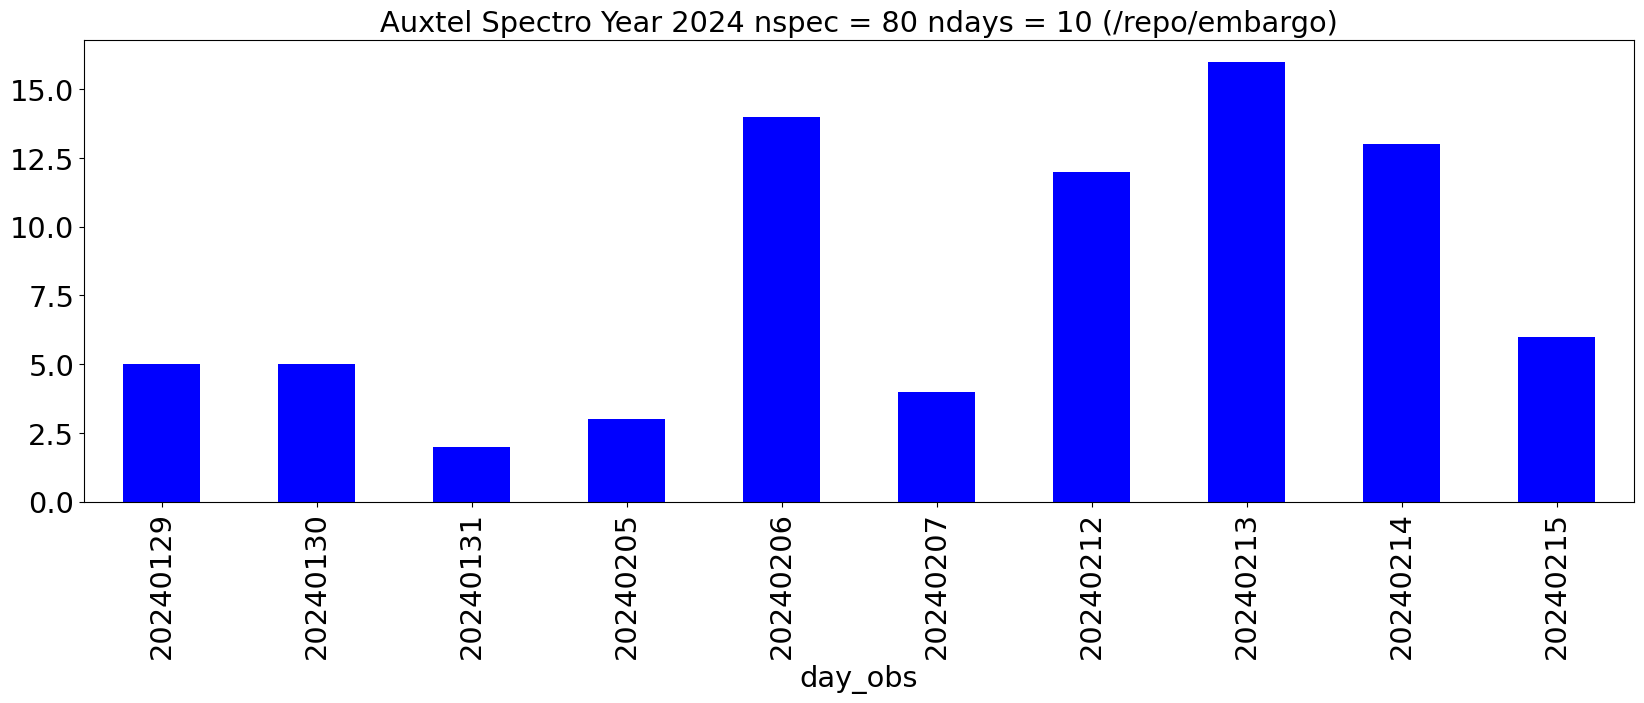

In [18]:
nspec = df_spec_visit.sum()
ndays = df_spec_visit.count()
suptitle = f"Auxtel Spectro Year 2024 nspec = {nspec} ndays = {ndays} (/repo/embargo)"
fig,ax = plt.subplots(1,1,figsize=(20,6))
df_spec_visit.plot(x='day_obs',kind="bar",facecolor="b",ax=ax)
ax.set_title(suptitle)

Text(0.5, 0, 'year,month,day')

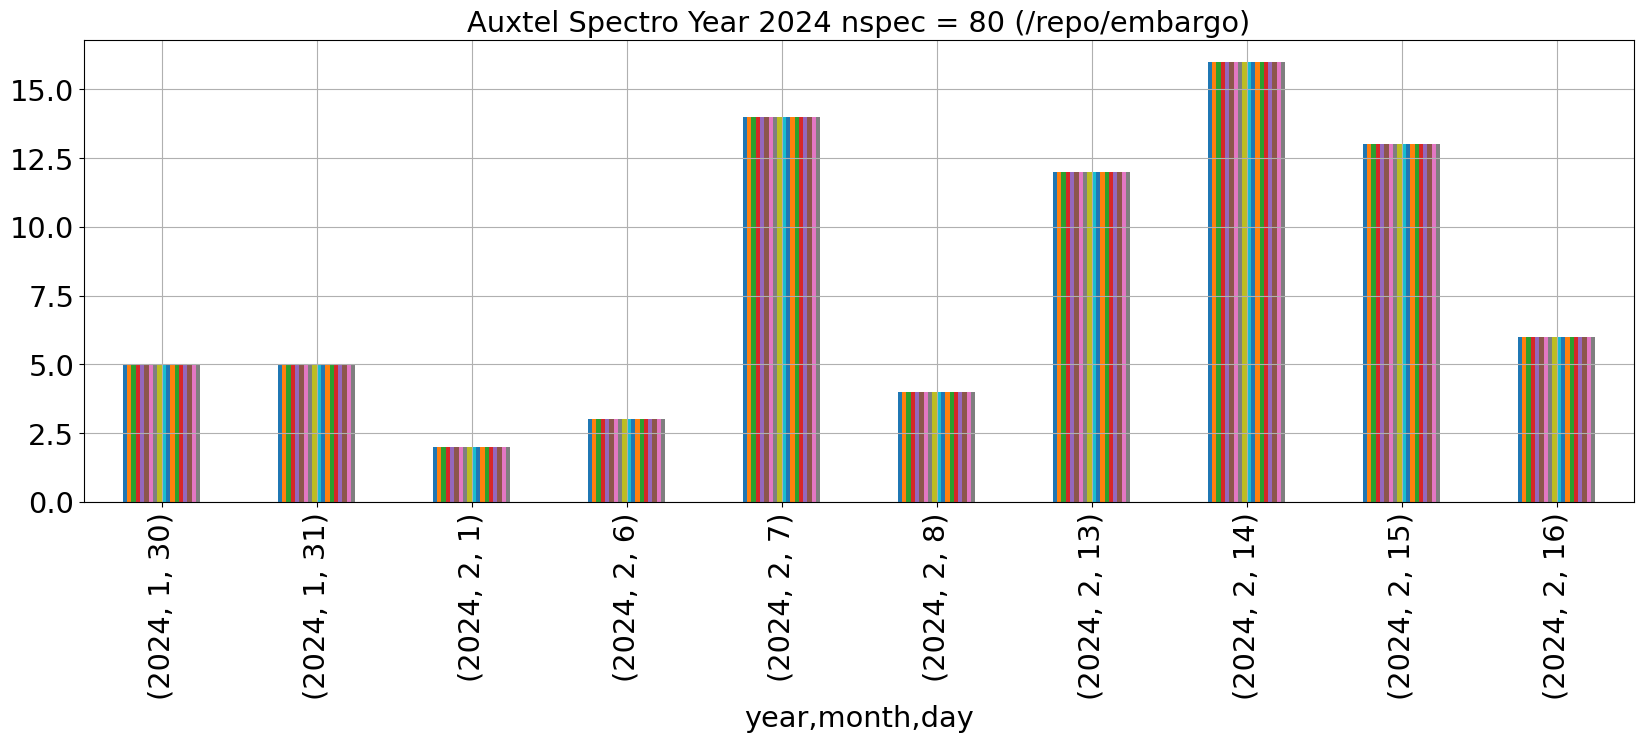

In [19]:
nspec = df_spec.id.count()
suptitle = f"Auxtel Spectro Year 2024 nspec = {nspec} (/repo/embargo)"
fig,ax = plt.subplots(1,1,figsize=(20,6))
df_spec.groupby([df_spec["time"].dt.year, df_spec["time"].dt.month,df_spec["time"].dt.day]).count().plot(kind="bar",ax=ax,legend=False,grid=True)
ax.set_title(suptitle)
ax.set_xlabel("year,month,day")

## Save the series

In [20]:
df_spec_visit.to_csv("spec_series_repo_embargo_29jan-15feb2024.csv")

In [21]:
df_2024 = df_spec[df_spec.year == 2024]

### Year 2024

In [22]:
df_2024["day_obs"].unique()

array([20240129, 20240130, 20240131, 20240205, 20240206, 20240207,
       20240212, 20240213, 20240214, 20240215])

In [23]:
df_spec["filter"].unique()

array(['empty~holo4_003'], dtype=object)

In [24]:
df_spec.target.unique()

array(['HD38666', 'HD185975', 'HD2811'], dtype=object)

In [25]:
df_spec.science_program.unique()

array(['spec-survey'], dtype=object)

In [26]:
df_spec.obs_reason.unique()

array(['object'], dtype=object)

## Plot Year 2024

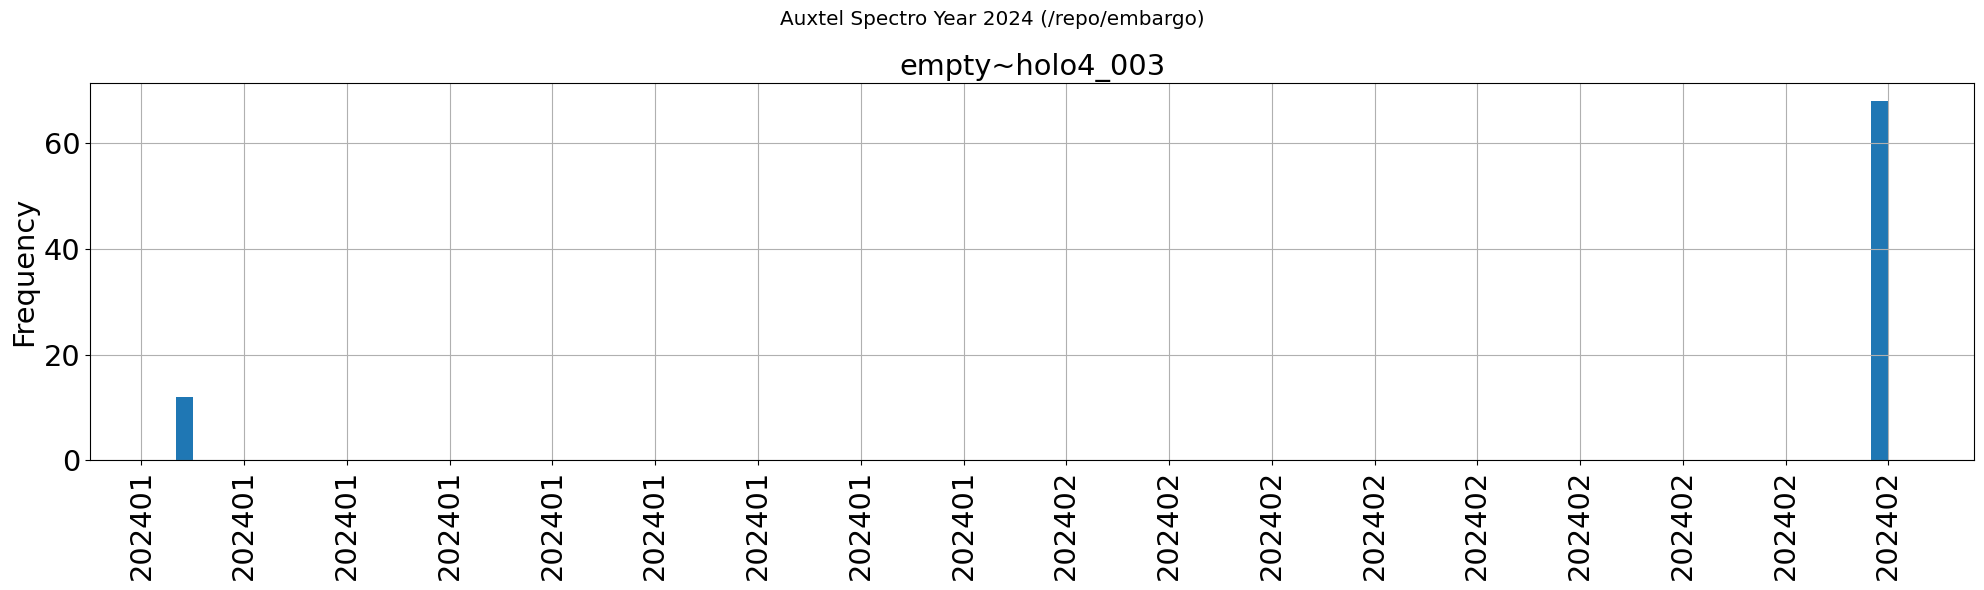

In [27]:
suptitle = "Auxtel Spectro Year 2024 (/repo/embargo)"
fig,ax = plt.subplots(1,1,figsize=(20,6))
df_2024.plot.hist(column=["yearmonth"] ,by="filter",bins=100,grid=True,ax=ax,legend=False)


# plot x axis as an int
locator = matplotlib.ticker.MultipleLocator(1)

plt.gca().xaxis.set_major_locator(locator)
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=90)

plt.suptitle(suptitle)
plt.tight_layout()

In [28]:
df_2024.id.count()

80

Text(0.5, 0, 'year,month,day')

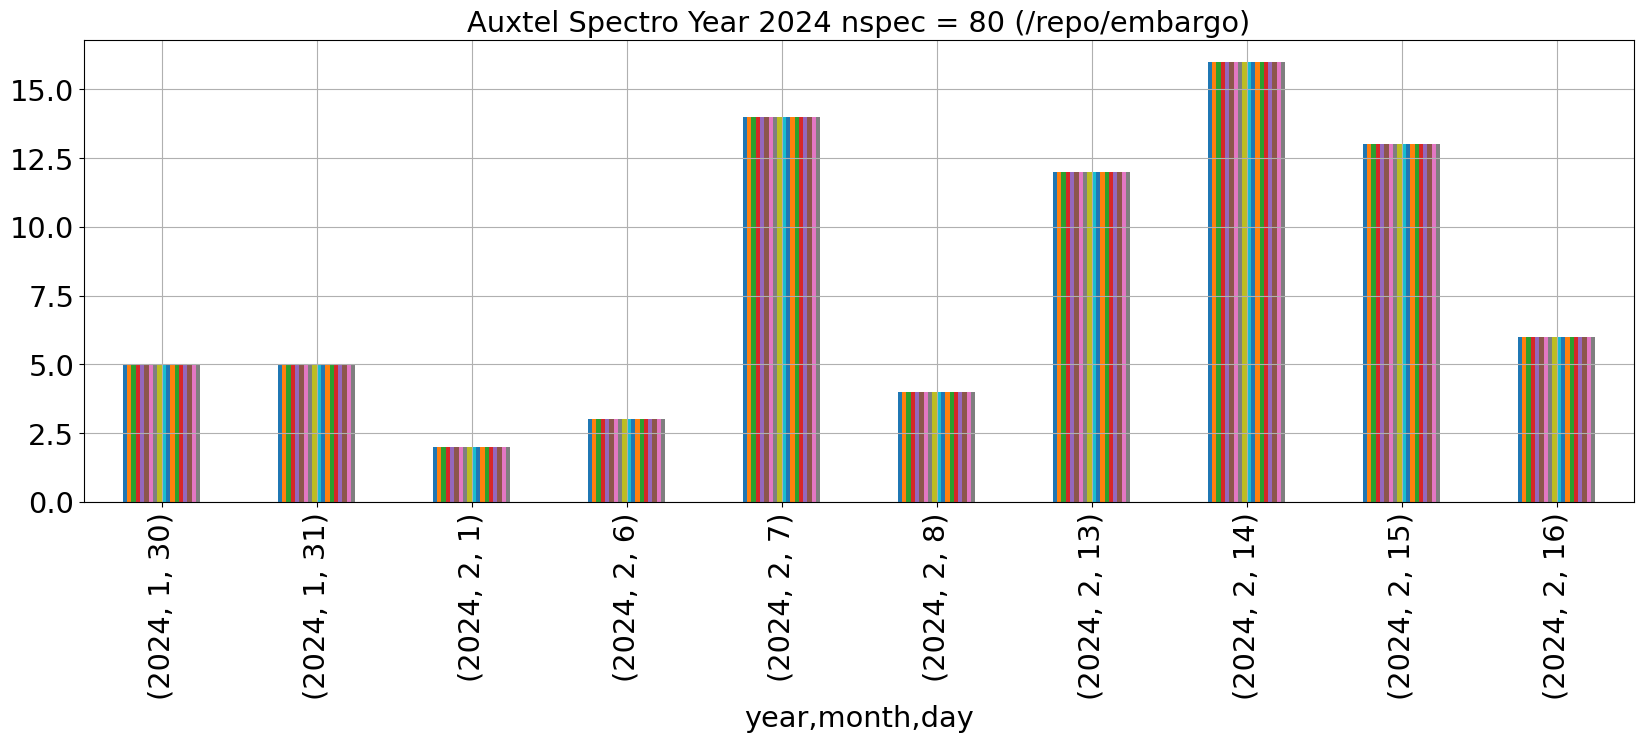

In [29]:
nspec = df_2024.id.count()
suptitle = f"Auxtel Spectro Year 2024 nspec = {nspec} (/repo/embargo)"
fig,ax = plt.subplots(1,1,figsize=(20,6))
df_2024.groupby([df_2024["time"].dt.year, df_2024["time"].dt.month,df_2024["time"].dt.day]).count().plot(kind="bar",ax=ax,legend=False,grid=True)
ax.set_title(suptitle)
ax.set_xlabel("year,month,day")

### Plot Year 2024

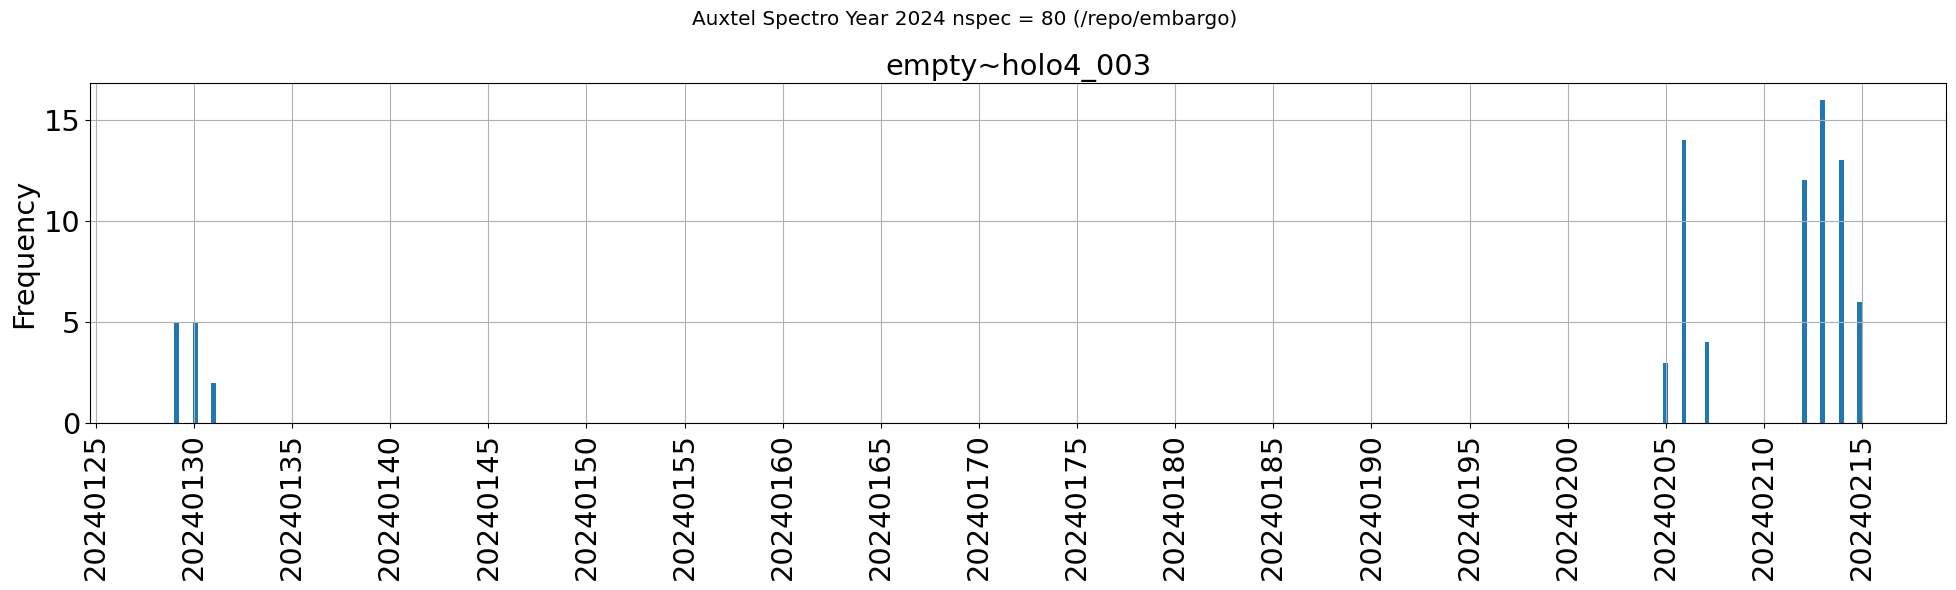

In [30]:
nspec = df_2024.id.count()
suptitle = f"Auxtel Spectro Year 2024 nspec = {nspec} (/repo/embargo)"

fig,ax = plt.subplots(1,1,figsize=(20,6))
df_2024.plot.hist(column=["day_obs"] ,by="filter",bins=365,grid=True,ax=ax,legend=False)


# plot x axis as an int
locator = matplotlib.ticker.MultipleLocator(1)

plt.gca().xaxis.set_major_locator(locator)
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=90)

plt.suptitle(suptitle)
plt.tight_layout()

Text(0.5, 0, 'year,month,day')

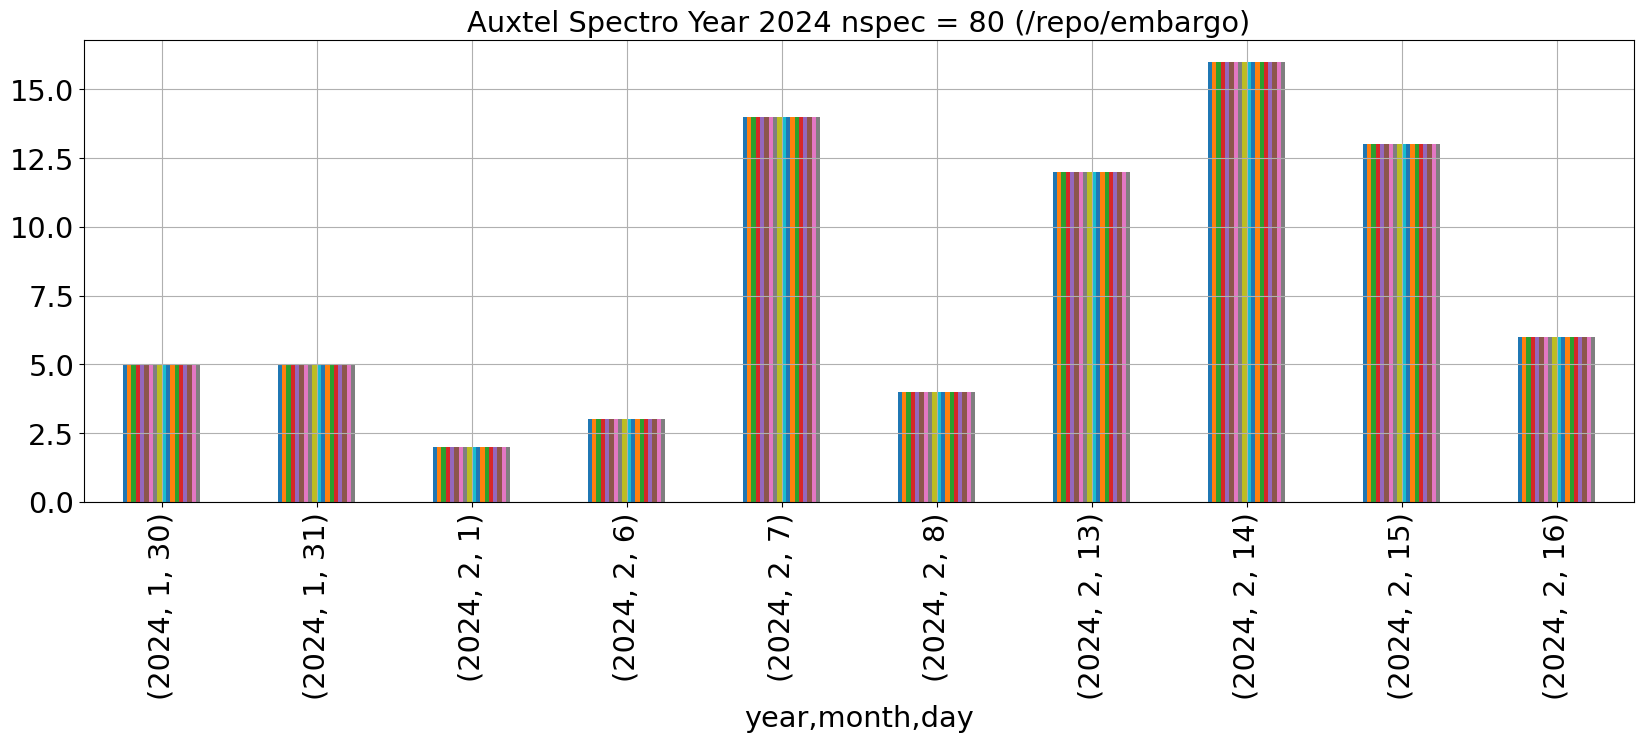

In [31]:
nspec = df_2024.id.count()
suptitle = f"Auxtel Spectro Year 2024 nspec = {nspec} (/repo/embargo)"

fig,ax = plt.subplots(1,1,figsize=(20,6))
df_2024.groupby([df_2024["time"].dt.year, df_2024["time"].dt.month,df_2024["time"].dt.day]).count().plot(kind="bar",ax=ax,legend=False,grid=True)
ax.set_title(suptitle)
ax.set_xlabel("year,month,day")

# Visits

In [32]:
df_spec_visit.cumsum()

day_obs
20240129     5
20240130    10
20240131    12
20240205    15
20240206    29
20240207    33
20240212    45
20240213    61
20240214    74
20240215    80
Name: countVisitperBandperNight, dtype: int64

In [33]:
def convertNumToDatestr(num):
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)

In [34]:
dt = [ convertNumToDatestr(num) for num in df_spec_visit.index ]

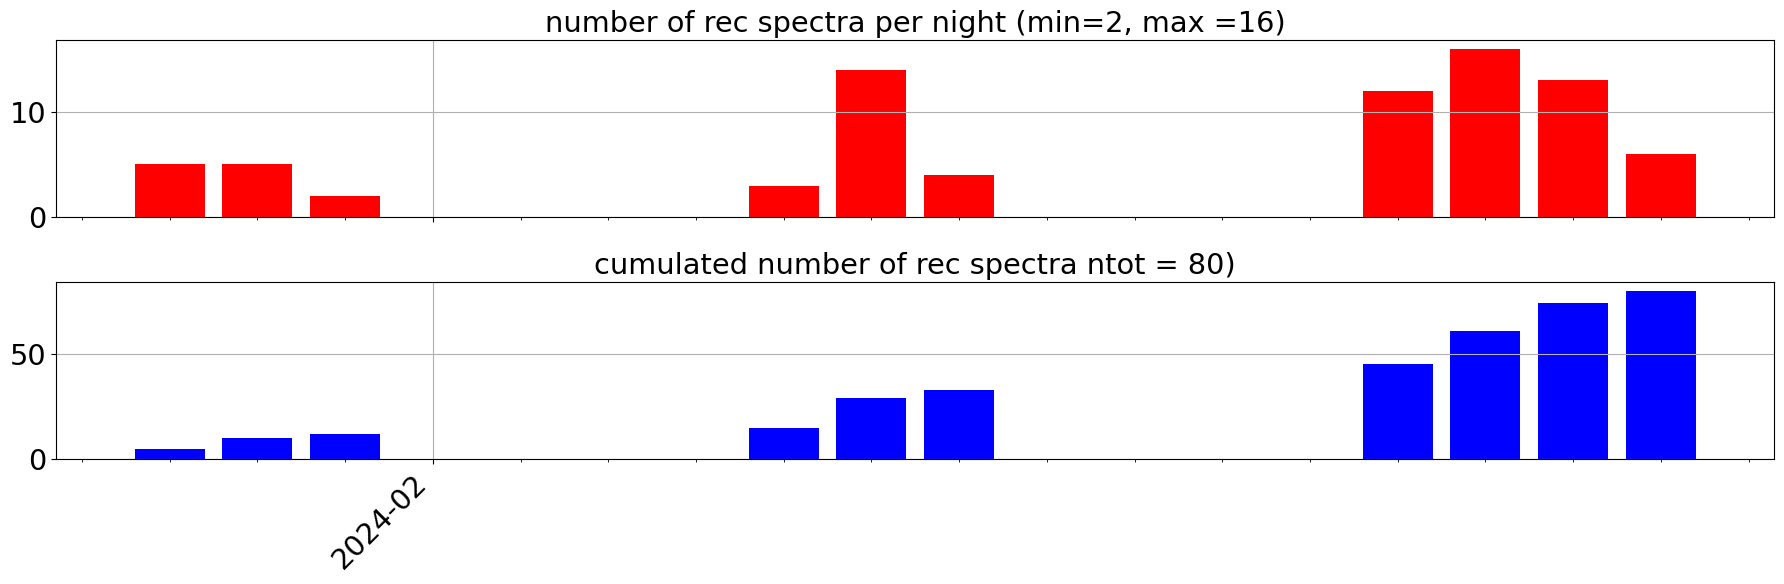

In [35]:
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(18, 6),sharex=True)


# fit 1
#ax.plot(dt,df_spec_visit.values,marker='o', markersize=15,lw=0)
ax1.bar(dt,df_spec_visit.values,lw=5,facecolor='r')
ax1.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax1.xaxis.set_minor_locator(day_locator)
ax1.xaxis.set_major_formatter(year_month_formatter)
ax1.grid()

minnspec= df_spec_visit.min()
maxnspec= df_spec_visit.max()
totnspec= df_spec_visit.sum()
title1 = f"number of rec spectra per night (min={minnspec}, max ={maxnspec})"
ax1.set_title(title1)

#fig.autofmt_xdate() # rotation
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=45, ha='right')

ax2.bar(dt,df_spec_visit.cumsum().values,lw=5,facecolor='b')
ax2.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax2.xaxis.set_minor_locator(day_locator)
ax2.xaxis.set_major_formatter(year_month_formatter)
ax2.grid()

#fig.autofmt_xdate() # rotation
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right')
title2 = f"cumulated number of rec spectra ntot = {totnspec})"
ax2.set_title(title2)

plt.tight_layout()